Please open in Colab to view HTML content correctly:
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/setupishe/TheBaldRule/blob/main/the-bald-rule.ipynb)

# The crux of the problem

In [1]:
import requests # Handling requests
from bs4 import BeautifulSoup # Parsing HTML documents
from IPython.core.display import HTML #Displaying HTML content

# Get the response in the form of html
wikiurl="https://en.wikipedia.org/wiki/Bald%E2%80%93hairy"
response=requests.get(wikiurl)
if str(response) != '<Response [200]>':
   raise Exception('Can not load web page!')

# Parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')

#Find annotation and table
annotation = soup.find_all('p')[0]
table=soup.find('table',{'class':"wikitable"})

#Display the content
HTML(str(annotation)+str(table))


# Setting up the model

In [2]:
import torchvision            # The main nn framework we're going to use
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import models, datasets
from torch import optim
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt  # Plotting and image display
%matplotlib inline

import cv2, glob, numpy as np    # Operations with images, pathfiles & arrays
from glob import glob

!pip install torchsummary
from torchsummary import summary     # Summarizing model's parameters

In [3]:
gpu_on = torch.cuda.is_available()
device = 'cuda' if gpu_on else 'cpu'
print(gpu_on)

True


In [4]:
#import gc  # CLEANING MEMORY IN CASE OF GPU MEMORY SHORTAGE

#gc.collect()

#torch.cuda.empty_cache()

In [5]:
# We are using Kaggle Dataset posted by ASHISH JANGRA consisting of 200r images
train_data_dir = '/kaggle/input/bald-classification-200k-images-celeba/Dataset/Train'
val_data_dir = '/kaggle/input/bald-classification-200k-images-celeba/Dataset/Validation'
test_data_dir = '/kaggle/input/bald-classification-200k-images-celeba/Dataset/Test'

In [6]:
class baldnbald(Dataset):
  '''Pytorch Dataset class storing images of bald and non-bald people.
  size argument is used to limit the whole set to mini-set
  aug argument is used for random data augmentation
  '''
  def __init__(self, folder, size=0, aug=None):
    halfsize = int(size/2)
    # Collecting paths to images
    bald = glob(folder+'/Bald/*.jpg')   
    nbald = glob(folder+'/NotBald/*.jpg')
    if size != 0:
        self.fpaths = bald[:halfsize] + nbald[:halfsize]
    else:
        self.fpaths = bald + nbald
    from random import shuffle, seed; seed(10); shuffle(self.fpaths)
    # Labeling images
    self.targets = [fpath.split('/')[-2].startswith('Bald') for fpath in 
                    self.fpaths]
    self.aug = aug
  def __len__(self): 
    return len(self.fpaths)

  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f)[:,:,::-1])
    # Performing data scaling
    im = torch.tensor(im/255).permute(2,0,1)
    # Extending 178x218 picture to square shape
    im = T.Pad(padding = (40, 0, 0, 0))(im)
    if self.aug: im = self.aug(im)
    return im.to(device).float(), torch.tensor([target]).float().to(device)


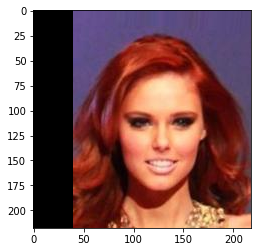

In [7]:
# Let's try making a dataset and showing random image from it
data = baldnbald(train_data_dir, size=7000)
len(data)
im, label = data[7]
plt.imshow(im.permute(1,2,0).cpu())

In [8]:
# Defining the model. We will use Convolutional Meural Network as it shows great
# performance in image recognition 
def conv_layer(ni,no,kernel_size,stride=1):
    '''Defines and returns basic CNN bulding block'''
    return nn.Sequential(
    nn.Conv2d(ni, no, kernel_size, stride),
    nn.ReLU(),
    # Using batch normalisation to avoid too small gradients
    nn.BatchNorm2d(no),
    nn.MaxPool2d(2)
    )
def get_model():
    ''' Defines and returns Pytorch model'''
    model = nn.Sequential(
    # Using dropout to avoid overfitting
    conv_layer(3, 64, 3),
    conv_layer(64, 512, 3),
    conv_layer(512, 512, 3),
    conv_layer(512, 512, 3),
    conv_layer(512, 512, 3),
    conv_layer(512, 512, 3),
    nn.Flatten(),
    nn.Linear(512, 1),
    nn.Dropout(0.25),
    nn.Sigmoid(),
    ).to(device)
    #Using DCELoss since we are working on binary classification case
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model, loss_fn, optimizer

In [9]:
def train_batch(x, y, model, opt, loss_fn):
    '''Executes forward- and backpropagation process for one batch
    Returns loss
    '''
    model.train()
    prediction = model(x)
    #Using L2 regularisation to avoid overfitting
    l_regularization = 0
    for param in model.parameters():
          l_regularization += torch.norm(param,2)
    batch_loss = loss_fn(prediction, y) + 0.005*l_regularization
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def evaluate(x, y, model):
    '''Calculates performance metrics of a model from one batch
    Returns precision, recall and accuracy
    '''
    model.eval()
    prediction = model(x)
    TP = torch.eq((prediction > 0.5), y == 1)
    TN = torch.eq((prediction <= 0.5), y == 0)
    FP = torch.eq((prediction > 0.5),  y == 0)
    FN = torch.eq((prediction <= 0.5),  y == 1)
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    return precision.cpu().numpy().tolist(), recall.cpu().numpy().tolist(), accuracy.cpu().numpy().tolist()

In [16]:
def get_data():     
    '''Returns training and validation dataloaders'''
    # Since raining and validation folders contain ~3500 and ~350 bald images,
    # we will use  size parameter to limit datasets so that bald and non-bald 
    # parts are equal
    train = baldnbald(train_data_dir, size=7000, aug=T.RandomAffine(degrees=0, scale=(0.15, 1)))
    trn_dl = DataLoader(train, batch_size=50, shuffle=True, drop_last = True)
    val = baldnbald(test_data_dir, size=700)
    val_dl = DataLoader(val, batch_size=50, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [11]:
@torch.no_grad()
def val_loss(x, y, model):
    '''Calculates loss for one batch obtained from validation datloader'''
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [54]:
# Initialising dataloaders and model
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()
# Printing summary
summary(model, input_size=(3, 218, 218))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 216, 216]           1,792
              ReLU-2         [-1, 64, 216, 216]               0
       BatchNorm2d-3         [-1, 64, 216, 216]             128
         MaxPool2d-4         [-1, 64, 108, 108]               0
            Conv2d-5        [-1, 512, 106, 106]         295,424
              ReLU-6        [-1, 512, 106, 106]               0
       BatchNorm2d-7        [-1, 512, 106, 106]           1,024
         MaxPool2d-8          [-1, 512, 53, 53]               0
            Conv2d-9          [-1, 512, 51, 51]       2,359,808
             ReLU-10          [-1, 512, 51, 51]               0
      BatchNorm2d-11          [-1, 512, 51, 51]           1,024
        MaxPool2d-12          [-1, 512, 25, 25]               0
           Conv2d-13          [-1, 512, 23, 23]       2,359,808
             ReLU-14          [-1, 512,

# Training

In [13]:
import matplotlib.ticker as mtick
import matplotlib.ticker as mticker
from time import sleep              #training progressbar
from tqdm.notebook import tqdm
from torch import optim             #using learningrate scheduler


In [55]:
# Initialising lists for plotting later
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
epochs = []

In [ ]:
# Using learning rate annealing to avoid leaping over optimum
# This scheduler lowers lr exponentially over epochs
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, verbose=True)

# We are going to display training progress and plot accuracy on-the-go, however,
# this cell's output is omited here for brevity. Model's final perfomance plots
# will be shown later
for epoch in range(10):
    
    print('epoch: ', epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    
    #Training on training dataset once and calculating mean loss
    tbar = tqdm(iter(trn_dl))
    for batch in tbar:
        tbar.set_description("Training")
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()
    scheduler.step()

    #Calculating accuracy on training dataset
    tvbar = tqdm(iter(trn_dl))
    for batch in tvbar:
        tvbar.set_description("Calculating train accuracy")
        x, y = batch
        _, __, is_correct = evaluate(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    #Calculating accuracy and loss on validation dataset   
    vbar = tqdm(iter(val_dl))
    for batch in vbar:
        vbar.set_description("Calculating validation accuracy")
        x, y = batch
        _, __, val_is_correct = evaluate(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)
    
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

    # On-the-go plotting
    epochs.append(epoch + 1)
    %matplotlib inline
    plt.clf()
    plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.title('Training and validation accuracy with 7K data points used for training')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    #plt.ylim(0.8,1)
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
    plt.legend()
    plt.grid('off')
    plt.show()

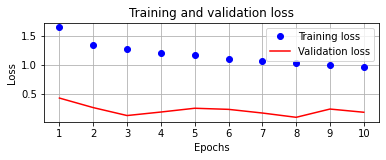

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator


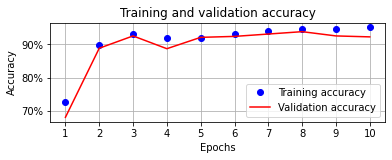

In [59]:
# Model's final perfomance plots
# As we see, validation accuracy and loss stop to grow 
# somewhere after 6-7 epoch and rests between 95-96%
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

# Testing
Let's test our trained model on separate subset and calculate some metrics:

In [163]:
def get_test_data(): 
    '''Returns testing dataloader'''
    test = baldnbald(test_data_dir)
    tst_dl = DataLoader(test, batch_size=100, shuffle=True, drop_last = True)
    return tst_dl

In [164]:
tst_dl = get_test_data()

In [165]:
test_losses, test_accuracies, test_recalls, test_precisions = [], [], [], []
tstbar = tqdm(iter(tst_dl))
for batch in tstbar:
    tstbar.set_description("Testing")
    x, y = batch
    precision, recall, accuracy = evaluate(x, y, model)
    test_recalls.extend(recall)
    test_precisions.extend(precision)
    test_accuracies.extend(accuracy)

print(f'average recall = {np.mean(test_recalls)}')
print(f'average precision = {np.mean(test_precisions)}')
print(f'average accuracy = {np.mean(test_accuracies)}')

  0%|          | 0/200 [00:00<?, ?it/s]

average recall = 0.92045
average precision = 0.92045
average accuracy = 0.92045


Nice! Now let's take a glance on first-layer filters:

In [ ]:
x1, y1 = next(iter(tst_dl))

torch.Size([3, 218, 218])
torch.Size([64, 108, 108])


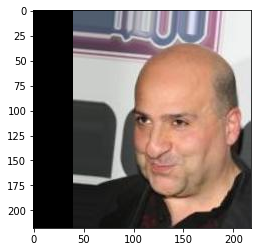

In [118]:
im = x1[0]
plt.imshow(im.permute(1,2,0).cpu())
print(im.size())
first_layer = nn.Sequential(*list(model.children())[:1])
intermediate_output = first_layer(im.unsqueeze(0))[0].detach()
print(intermediate_output.size())


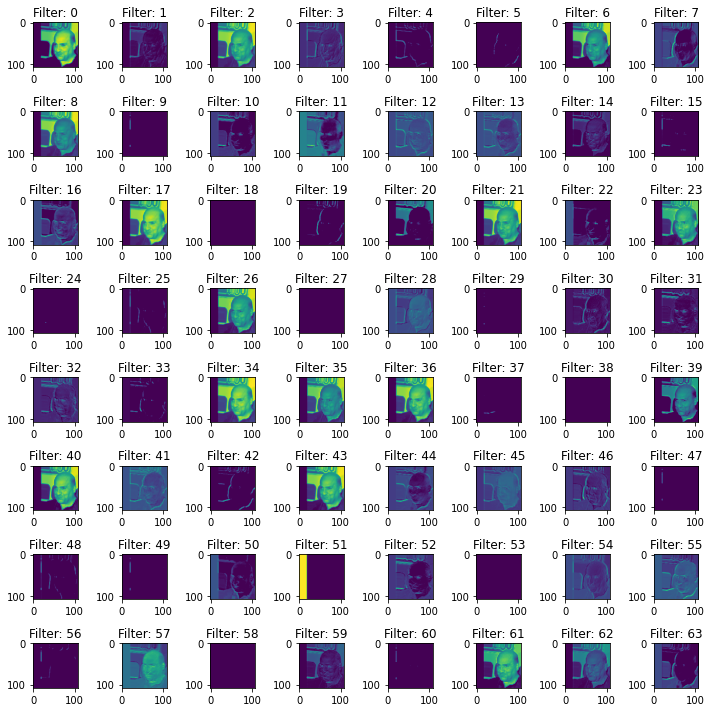

In [119]:
n = 8
fig, ax = plt.subplots(n, n, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.set_title('Filter: '+str(ix))
    axis.imshow(intermediate_output[ix].cpu())
plt.tight_layout()
plt.show()

The plot shows that fisrt-layer filters mostly concentrate on finding edges of the head.
Let's grab some random images and see is the model predicts their hairstyle correctly:

In [128]:
def baldornot(pred):
  '''Prettyfies float prediction, returns verbal result'''
  if pred > 0.5:
    return 'bald'
  else:
    return 'not bald'

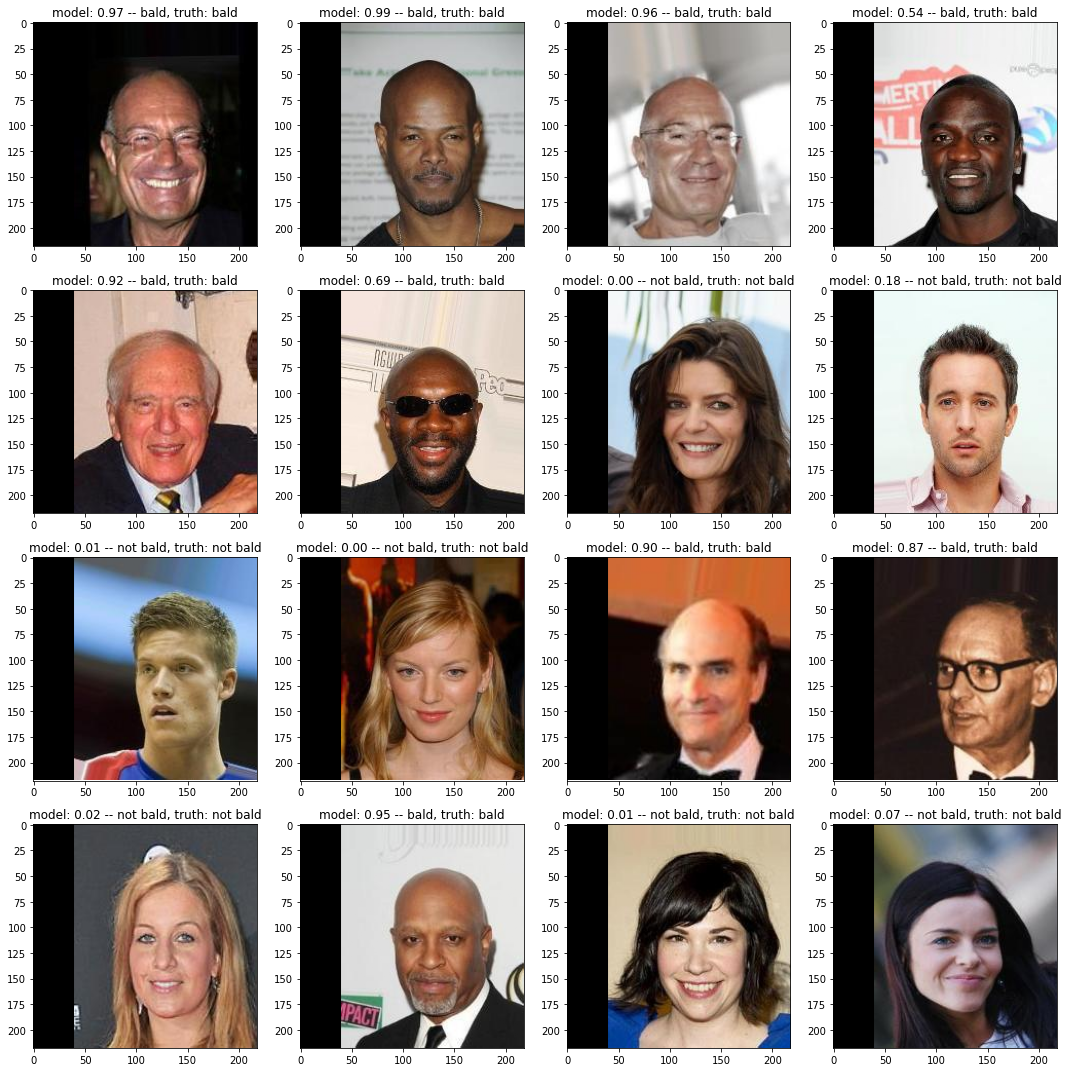

In [129]:
test = baldnbald(test_data_dir, size=700)
tst_dl = DataLoader(test, batch_size=100, shuffle=True, drop_last = True)
@torch.no_grad()
def grabsome(tst_dl, model):
    '''Shows predictions for random 16 images'''
    model.eval()
    x1, y1 = next(iter(tst_dl))
    pred = model(x1)
    fig, ax = plt.subplots(4, 4, figsize=(15,15))
    for i, axis in enumerate(ax.flat):
        axis.set_title(f'model: {float(pred[i]):.2f} -- {baldornot(float(pred[i]))}, truth: {baldornot(float(y1[i]))}')
        axis.imshow(x1[i].permute(1,2,0).cpu())
    plt.tight_layout()
    plt.show()
grabsome(tst_dl, model)

Seems neat! Now, finally, let's use the might of out model to answer the main question on the table:

# Can you run for the office?
This section takes photos of several politicions loaded from the internet (stacked under 'testset' dataset) and estimates their chances for becoming the next president of Russian Federation.

In [140]:
@torch.no_grad()
def nextpresident(im, model):
    '''Estimates if the person on the photo could be the next president
    Returns float prediction
    '''
    model.eval()
    #reading and transforming image
    im = torch.tensor(im/255).permute(2,0,1)
    width, height = im.shape[1:]
    delta = height - width
    if delta < 0:
      transform = T.Pad(padding = (0, 0, delta*(-1), 0))
    else:
      transform = T.Pad(padding = (0, delta, 0, 0))
    im = transform(im)
    im = T.functional.resize(im, size = [218])
    im = im.unsqueeze(0).to(device).float()
    pred = model(im)
    return float(pred)

In [161]:
test_set_dir = '/kaggle/input/testset/'
rootdir = glob(test_set_dir + '*.jpg')
print(rootdir)
print(len(rootdir))

['/kaggle/input/testset/Vasily_Nebenzya_(2020-02-03).jpg', '/kaggle/input/testset/20190819-The-Politician-01.jpg', '/kaggle/input/testset/test.jpg', '/kaggle/input/testset/portrait-young-good-looking-male-posing-like-politician-businessman-29727775.jpg', '/kaggle/input/testset/politician-201-unit-02322r-1589811211.jpg', '/kaggle/input/testset/pwa_vertical_1280_2aad12d4f02a609af1f7bd8e704179bb.jpg', '/kaggle/input/testset/images.jpg', '/kaggle/input/testset/aaaa.jpg']
8


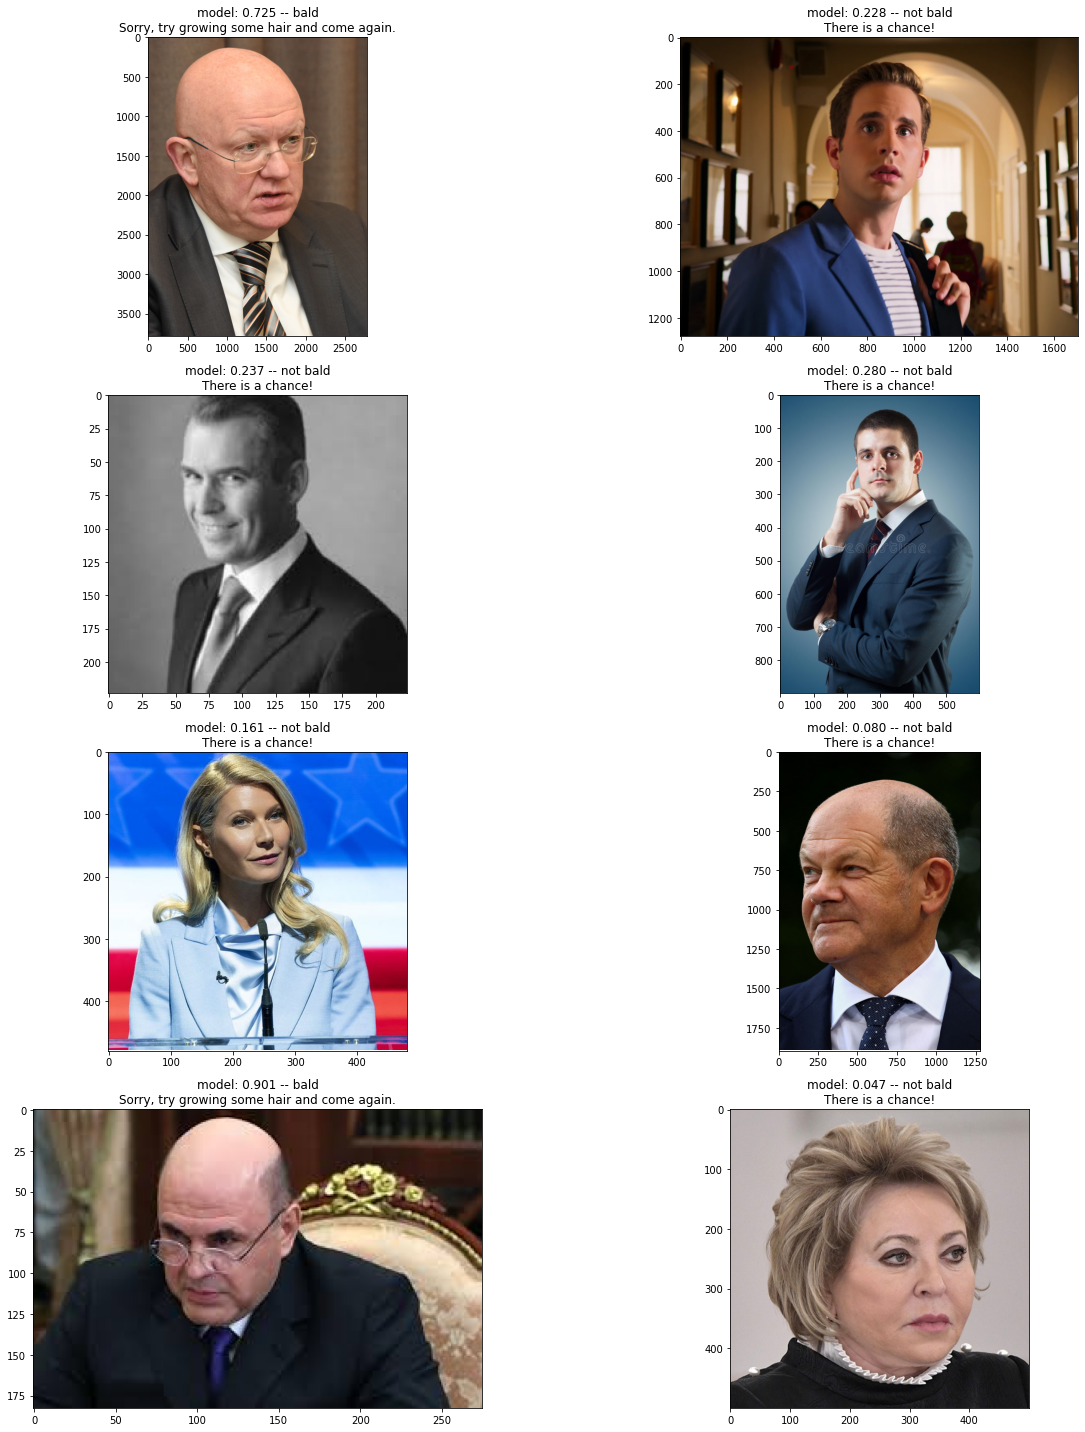

In [162]:

fig, ax = plt.subplots(4, 2, figsize=(20,20))

for i, path in enumerate(rootdir):
    im = cv2.imread(path)[:,:,::-1]
    pred = nextpresident(im, model)
    axis = ax.flat[i]
    basetitle = f'model: {pred:.3f} -- {baldornot(pred)}'
    if float(pred) <= 0.5:
        judgement = 'There is a chance!'
    else:
        judgement = 'Sorry, try growing some hair and come again.'
    axis.set_title(basetitle + '\n' + judgement)
    axis.imshow(im)
    
plt.tight_layout()
plt.show()

As we see, model evaluated candidates for the presidential run correctly, stumbling only on Olaf Scholz.